# Stroke Prediction

## 1 - Loading Data & Exploratory Analysis

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import scipy

from dython.nominal import associations

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv', index_col='id')
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


We can see above there are null values in the BMI column, these will perhaps need to be imputed for accuracy

In [4]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


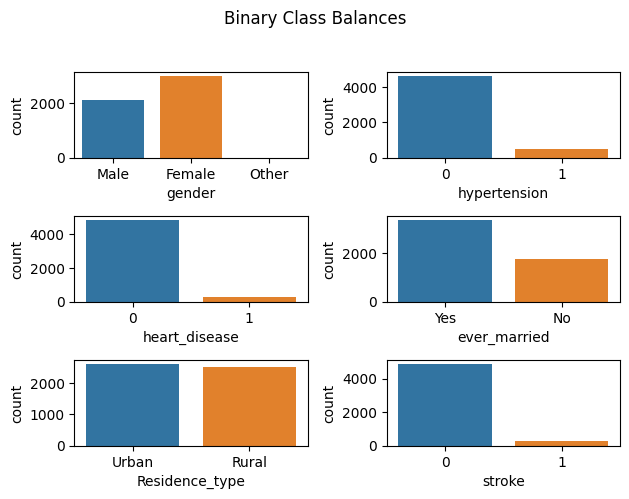

In [5]:
fig, ax = plt.subplots(3, 2)

sns.countplot(ax=ax[0,0], x="gender", data = df);
sns.countplot(ax=ax[0,1], x="hypertension", data = df);
sns.countplot(ax=ax[1,0], x="heart_disease", data = df);
sns.countplot(ax=ax[1,1], x="ever_married", data = df);
sns.countplot(ax=ax[2,0], x="Residence_type", data = df, orient="h");
sns.countplot(ax=ax[2,1], x="stroke", data = df);

fig.suptitle("Binary Class Balances",  y= 1.03)

fig.tight_layout()

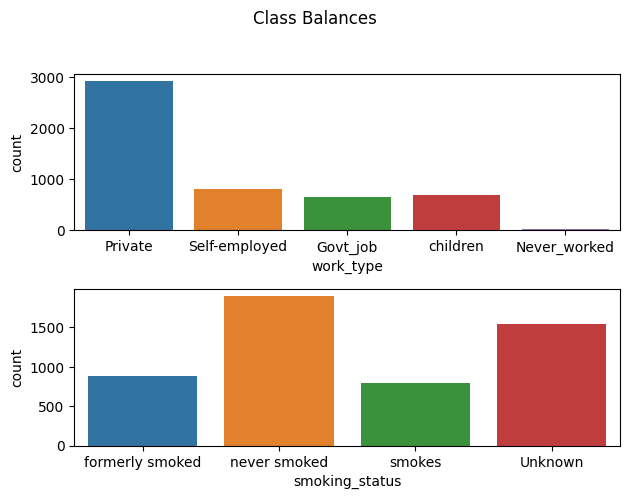

In [6]:
fig, ax = plt.subplots(2,1)

sns.countplot(ax=ax[0], x="work_type", data = df);
sns.countplot(ax=ax[1], x="smoking_status", data = df);

fig.suptitle("Class Balances",  y= 1.03)

fig.tight_layout()

From the above class balanaces, it appears that the data is biased towards these groups of individuals:
* Females
* Individuals not exhibiting hypertension
* Individuals not exhibiting heart disease
* Married individuals
* Individuals working in the private sector
* Non-smokers

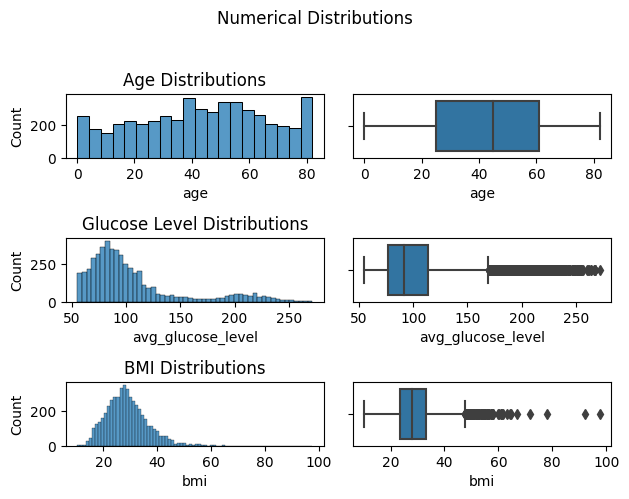

In [7]:
fig, ax = plt.subplots(3, 2)

sns.histplot(ax=ax[0,0], data=df, x="age");
sns.boxplot(ax=ax[0,1], data=df, x="age");
sns.histplot(ax=ax[1,0], data=df, x="avg_glucose_level");
sns.boxplot(ax=ax[1,1], data=df, x="avg_glucose_level");
sns.histplot(ax=ax[2,0], data=df, x="bmi");
sns.boxplot(ax=ax[2,1], data=df, x="bmi");

ax[0,0].set_title("Age Distributions")
ax[1,0].set_title("Glucose Level Distributions")
ax[2,0].set_title("BMI Distributions")

fig.suptitle("Numerical Distributions", y=1.03);
fig.tight_layout()

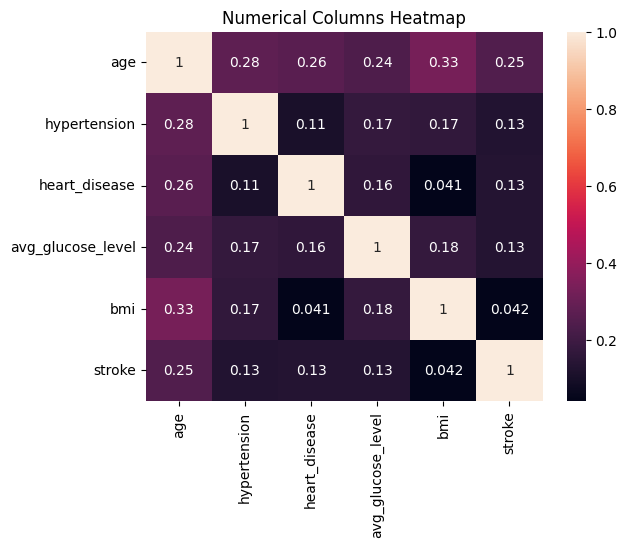

In [8]:
sns.heatmap(df.select_dtypes(exclude = "object").corr(), annot=True)
plt.title("Numerical Columns Heatmap");

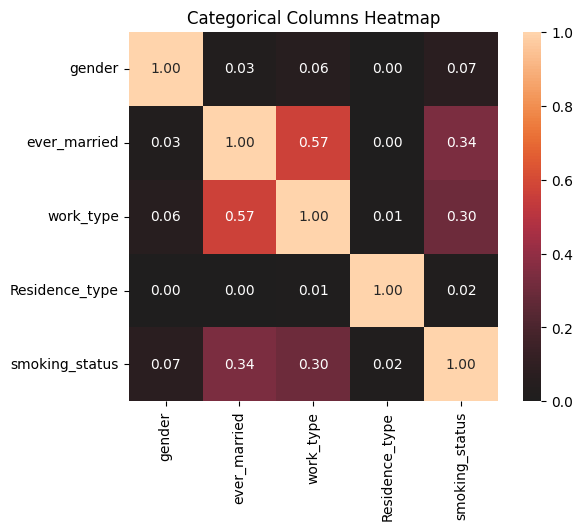

In [9]:
associations(df.select_dtypes("object"), title="Categorical Columns Heatmap");

From our correlation heatmap, we can see there is very little intercorrelation between numerical columns. Even the attributes which would one would assume to be correlated, do not seem to be so in this dataset. One such example is BMI and heart disease, which is widely considered to be linked. <br>
However, there appears to be a moderate correlation between work_type and ever_married. Although this is not an intuitive correlation, reasearch exists which suggests these are correlated - with marriage seen to drive men to work and the inverse for women. A research article by [International Labour Organisation](https://ilostat.ilo.org/international-day-of-families-how-marital-status-shapes-labour-market-outcomes/#:~:text=Workers'%20marital%20status%20also%20seems,opposite%20effect%20on%20women's%20careers.) goes further into this

## 2 - Wrangling & Feature Selection

Let us seperate the features from the target

In [10]:
target = 'stroke'

y = df[target]
X = df.drop(columns=target)

print(X.shape)
print(y.shape)
X["ever_married"].value_counts()
# X.head()

(5110, 10)
(5110,)


ever_married
Yes    3353
No     1757
Name: count, dtype: int64

To work with this data, we must convert all categorical variables into ordinal numbers, impute missing values and scale continuous variables. We will use ordinal encoding for categorical, as most of the categorical values follow some sort of 'order' or are binary (this will also reduce dimensionality when compared to one hot encoding)

In [11]:
def wrangle(X):
    # convert categorical to ordinal values
    cat_cols = X.select_dtypes('object').columns
    print(cat_cols)
    num_cols = ['age', 'avg_glucose_level', 'bmi']
    X[cat_cols] = OrdinalEncoder().fit_transform(X[cat_cols])
    
    #impute missing BMI values using iterative imputed
    ii = IterativeImputer(random_state=42)
    X_imp = pd.DataFrame(ii.fit_transform(X), columns=X.columns, index=X.index)
    
    # scale n
    X_imp[num_cols] = StandardScaler().fit_transform(X_imp[num_cols])
    return X_imp

In [12]:
X1 = wrangle(X)

print(X1.isnull().sum())
print(X1['ever_married'].value_counts())
X1.head()

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64
ever_married
1.0    3353
0.0    1757
Name: count, dtype: int64


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
9046,1.0,1.051434,0.0,1.0,1.0,2.0,1.0,2.706375,0.991246,1.0
51676,0.0,0.786070,0.0,0.0,1.0,3.0,0.0,2.121559,0.334909,2.0
31112,1.0,1.626390,0.0,1.0,1.0,2.0,0.0,-0.005028,0.460672,2.0
60182,0.0,0.255342,0.0,0.0,1.0,2.0,1.0,1.437358,0.706548,3.0
1665,0.0,1.582163,1.0,0.0,1.0,3.0,0.0,1.501184,-0.639301,2.0


In our exploratory analysis we saw a intercorrelation between features. Let us re-assess this with our scaled data

In [13]:
def corr_analysis(Xm):
    X_wrang = wrangle(X).astype('float')
    
    corr = X_wrang.corr()
    
    plt.figure(figsize=[10,8])
    sns.heatmap(corr, annot=True)
    plt.title("Correlation Matrix: All Features")
    plt.show()
    
    def intercorr():
        corr_thresh = 0.35
        cols2drop = []
        for col in range(len(corr.columns)):
            for row in range(col):
                if abs(corr.iloc[col, row]) > corr_thresh and abs(corr.iloc[col, row]) < 1:
                    cols2drop.append(corr.columns[col])
            
        return list(set(cols2drop))
        
    X_wrang.drop(columns=intercorr(), inplace=True)
    
    plt.figure(figsize=[10,8])
    sns.heatmap(X_wrang.corr(), annot=True)
    plt.title("Correlation Matrix: Reduced Features")
    plt.show()
    
    return X_wrang, intercorr()
   

Index([], dtype='object')


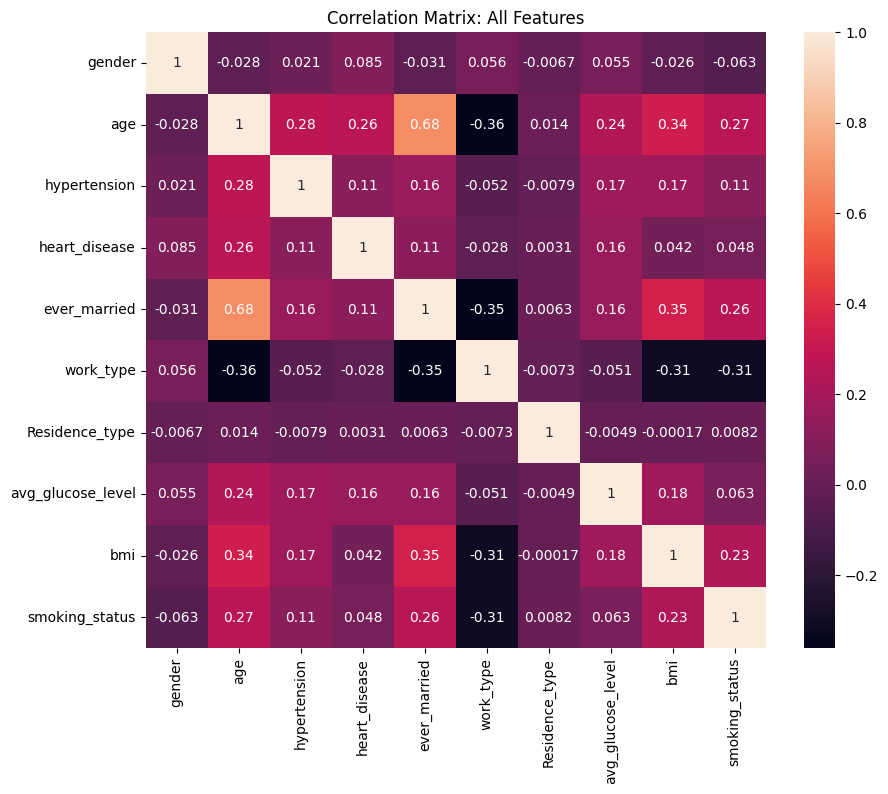

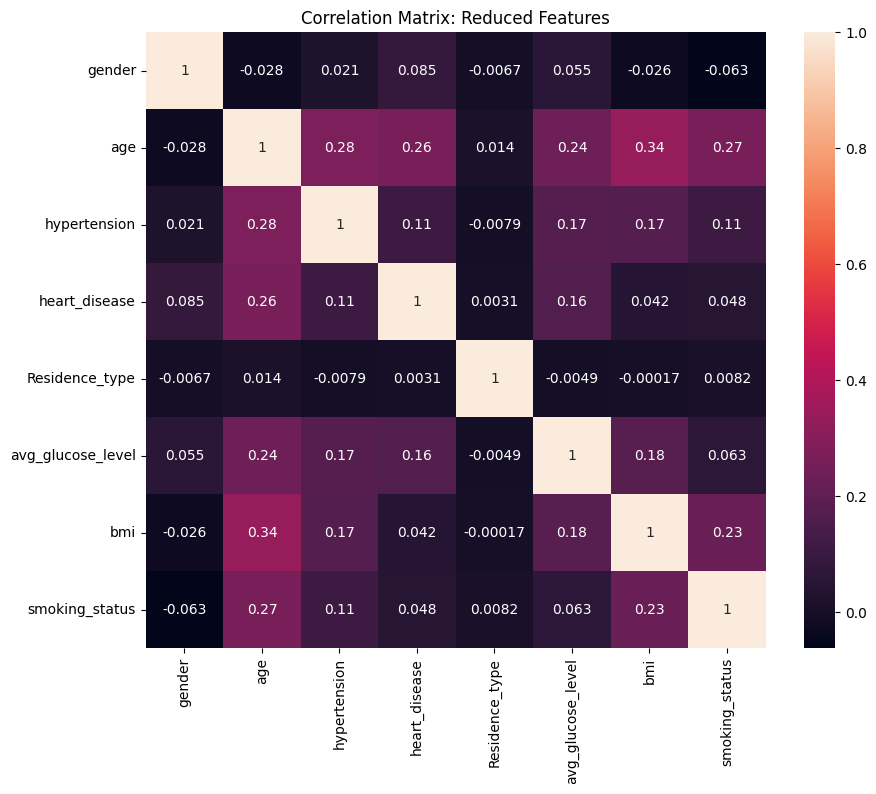

Columns dropped: ['work_type', 'ever_married']


In [14]:
X, cols_dropped= corr_analysis(X)
print(f"Columns dropped: {cols_dropped}")

Now we will split the features and targets into training, validation and test splits. We will use stratfied sampling for training data to ensure we have a representative sample of both positive and negative stroke diagnoses

In [15]:
X_train, X_vt, y_train, y_vt = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_vt,y_vt, test_size=0.5, random_state=42)

In [16]:
X_train.shape

(3577, 8)

In our exploratory analysis, we saw that there was a much greater proportion of patients who did not suffer strokes. We will counteract this by using Synthetic Minority Oversampling Technique (or SMOTE) to oversample our training data.

In [17]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

## 3 - Model Selection

### Naive Model Testing

First to establish which models to use, we will randomly test some common classification models on our validation data. We will only retain models with accuracy or recall score higher than 70%. Recall is of greater importance in this situation as we wish to avoid false negatives - a false negative could result in deaths! False positives is less of an issue in a 'better safe than sorry' manner.

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

classifiers = [KNeighborsClassifier(), SVC(), LinearSVC(), NuSVC(), DecisionTreeClassifier(), 
               RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier(), 
               GaussianNB(), LogisticRegression(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis()]

model_name = []
accuracy = []
precision = []
recall = []
f1 = []
for clf in classifiers:
    clf.fit(X_train_res, y_train_res)
    y_val_pred = clf.predict(X_val)
    
    model_name.append(type(clf).__name__) 
    accuracy.append(accuracy_score(y_val, y_val_pred))
    precision.append(precision_score(y_val, y_val_pred))
    recall.append(recall_score(y_val, y_val_pred))
    f1.append(f1_score(y_val, y_val_pred))

C:\Users\abhir\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\abhir\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


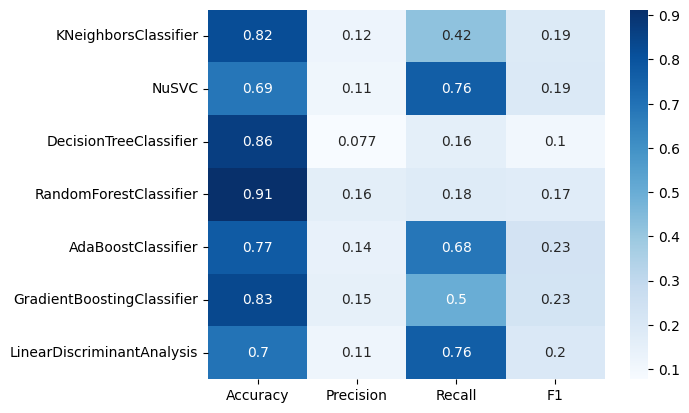

In [19]:
results = pd.DataFrame({'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1},
                      index=model_name)

models_to_test = results[(results["Accuracy"]>0.75) | (results["Recall"]>0.75)]
sns.heatmap(models_to_test, annot=True, cmap="Blues");

From this analysis, we will be testing the following models going forward:
* K Neighbors Classifier
* Nu Support Vector Classifier
* Random Forest Clasifier
* Adaptive Boost Classifier
* Gradient Boosting Classiifier
* Linear Discriminant Analysis

Nu-SVC, AdaBoost and Linear Discriminant Analysis seem to be the most promising, but let us see how promising these compare after hyperparameter tuning

### 3.1 K-Neighbors

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       728
           1       0.12      0.42      0.19        38

    accuracy                           0.82       766
   macro avg       0.54      0.63      0.54       766
weighted avg       0.92      0.82      0.86       766



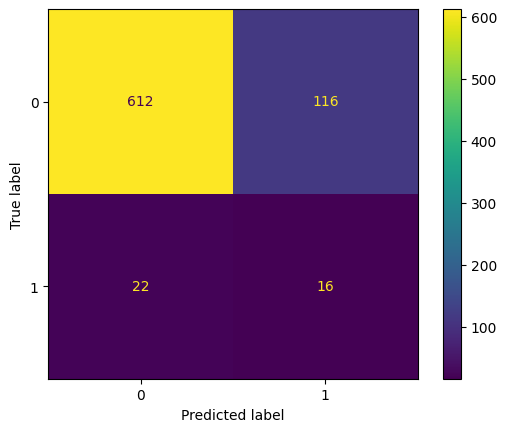

In [20]:
knn = KNeighborsClassifier()

knn.fit(X_train_res, y_train_res)

y_val_pred = knn.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm_disp_lr = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred))
cm_disp_lr.plot();

In [21]:
param_grid_knn = {
    'n_neighbors': [5,7,10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree'],
    'leaf_size': [10, 20, 30]
}

knn_hptune = GridSearchCV(knn, param_grid_knn, scoring='recall')
knn_hptune.fit(X_train_res, y_train_res)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'leaf_size': [10, 20, 30], 'n_neighbors': [5, 7, 10],
                         'weights': ['uniform', 'distance']},
             scoring='recall')

Best Logistic Regression Accuracy: 0.8159268929503917
Best Parameters: {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 7, 'weights': 'distance'}


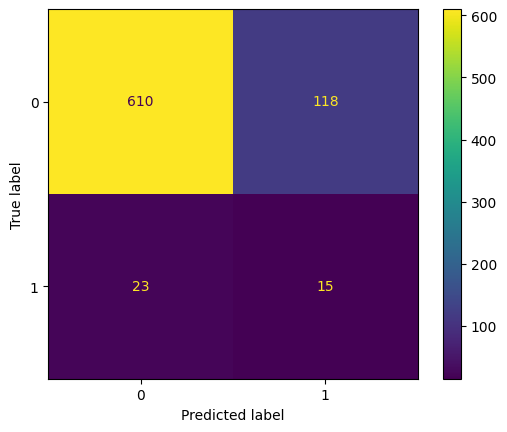

In [22]:
best_knn = knn_hptune.best_estimator_
print(f"Best Logistic Regression Accuracy: {best_knn.score(X_val, y_val)}")
print(f"Best Parameters: {knn_hptune.best_params_}")
cm_disp_knn = ConfusionMatrixDisplay(confusion_matrix(y_val, knn_hptune.predict(X_val)))
cm_disp_knn.plot();

K Neighbors does not appear to give satisfcatory results. Although realtively few false positives are generated, there are fewer true negatives than false negatives. An alternate model may be required

### 3.2 Nu-Support Vector Classification

              precision    recall  f1-score   support

           0       0.98      0.68      0.81       728
           1       0.11      0.76      0.19        38

    accuracy                           0.69       766
   macro avg       0.55      0.72      0.50       766
weighted avg       0.94      0.69      0.78       766



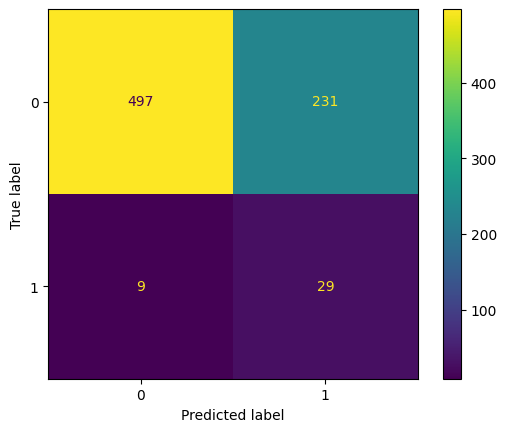

In [23]:
nu = NuSVC(random_state=42)

nu.fit(X_train_res, y_train_res)

y_val_pred = nu.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm_disp_nu = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred))
cm_disp_nu.plot();

In [24]:
param_grid_nu = {
    'nu': [0.25, 0.5, 0.75],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

nu_hptune = GridSearchCV(nu, param_grid_nu, scoring='recall')
nu_hptune.fit(X_train_res, y_train_res)

GridSearchCV(estimator=NuSVC(random_state=42),
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'nu': [0.25, 0.5, 0.75]},
             scoring='recall')

Best Logistic Regression Accuracy: 0.8407310704960835
Best Parameters: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.25}


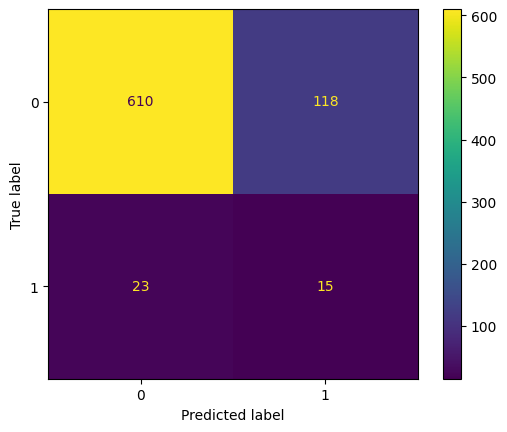

In [25]:
best_nu = nu_hptune.best_estimator_
print(f"Best Logistic Regression Accuracy: {best_nu.score(X_val, y_val)}")
print(f"Best Parameters: {nu_hptune.best_params_}")
cm_disp_nu = ConfusionMatrixDisplay(confusion_matrix(y_val, knn_hptune.predict(X_val)))
cm_disp_nu.plot();

Nu SVC was a very promising model. The initial model prodced very few false negatives and the tuned model identified false positives very well. This may be prove to be a very useful algorithm

### 3.3 Random Forest Classifier

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       728
           1       0.12      0.13      0.12        38

    accuracy                           0.91       766
   macro avg       0.54      0.54      0.54       766
weighted avg       0.91      0.91      0.91       766



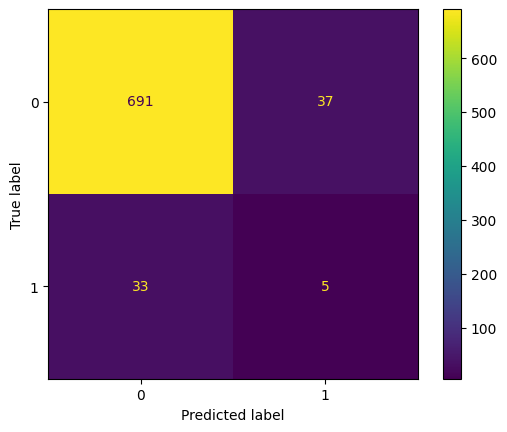

In [26]:
rfc = RandomForestClassifier(random_state=42)

rfc.fit(X_train_res, y_train_res)
y_val_pred = rfc.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm_disp_rfc = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred))
cm_disp_rfc.plot();

In [27]:
param_grid_rfc = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features' : ['sqrt', 'log2', None],
    'n_estimators': [10, 50, 100, 200]
}

rfc_hptune = GridSearchCV(rfc, param_grid_rfc, scoring='recall')
rfc_hptune.fit(X_train_res, y_train_res)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='recall')

Best Logistic Regression Accuracy: 0.9046997389033943
Best Parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 200}


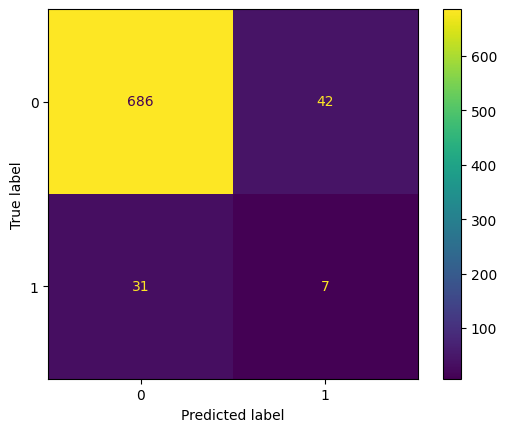

In [28]:
best_rfc = rfc_hptune.best_estimator_
print(f"Best Logistic Regression Accuracy: {best_rfc.score(X_val, y_val)}")
print(f"Best Parameters: {rfc_hptune.best_params_}")
cm_disp_rfc = ConfusionMatrixDisplay(confusion_matrix(y_val, rfc_hptune.predict(X_val)))
cm_disp_rfc.plot();

This model was very effective at identifying patients who did not suffer strokes but very ineffective at identifying those who did suffer strokes. This model may not be suitable for this project

### 3.4 Adaptive Boosting

              precision    recall  f1-score   support

           0       0.98      0.78      0.87       728
           1       0.14      0.68      0.23        38

    accuracy                           0.77       766
   macro avg       0.56      0.73      0.55       766
weighted avg       0.94      0.77      0.84       766



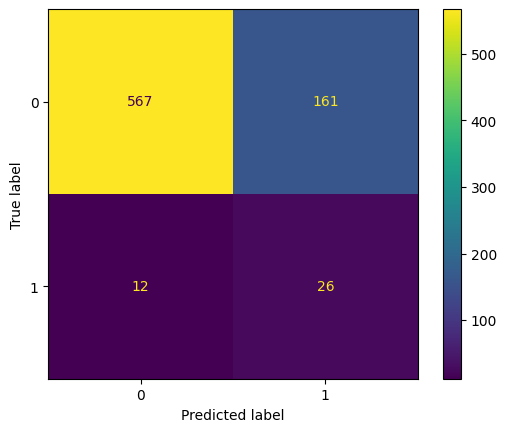

In [29]:
adab = AdaBoostClassifier(random_state=42)
adab.fit(X_train_res, y_train_res)

y_val_pred = adab.predict(X_val)

print(classification_report(y_val, y_val_pred))
  
cm_disp_lr = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred))
cm_disp_lr.plot();

In [30]:
param_grid_adab = {
    'n_estimators': [50, 100, 500],
    'learning_rate':[1, 1.1, 1.2, 1.3, 1.4],
    'algorithm': ['SAMME', 'SAMME.R']
} 

adab_hptune = GridSearchCV(adab, param_grid_adab, scoring="recall")
adab_hptune.fit(X_train_res, y_train_res)

GridSearchCV(estimator=AdaBoostClassifier(random_state=42),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [1, 1.1, 1.2, 1.3, 1.4],
                         'n_estimators': [50, 100, 500]},
             scoring='recall')

Best Logistic Regression Accuracy: 0.7389033942558747
Best Params: {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 100}


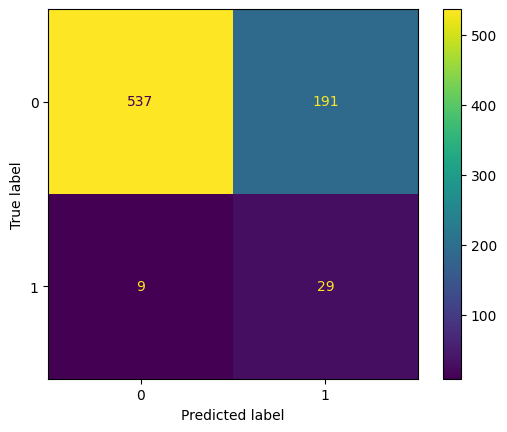

In [31]:
best_adab = adab_hptune.best_estimator_
print(f"Best Logistic Regression Accuracy: {best_adab.score(X_val, y_val)}")
print(f"Best Params: {adab_hptune.best_params_}")
cm_disp_adabcv = ConfusionMatrixDisplay(confusion_matrix(y_val, best_adab.predict(X_val)))
cm_disp_adabcv.plot()

This model appears to be the most effective aso far. It managed to identify 29 out of 38 stroke patients (76%). Although there was a low-moderate number of false positives, this was not as big a problem

### 3.5 Gradient Boosting Classifier

              precision    recall  f1-score   support

           0       0.97      0.85      0.91       728
           1       0.15      0.50      0.23        38

    accuracy                           0.83       766
   macro avg       0.56      0.68      0.57       766
weighted avg       0.93      0.83      0.87       766



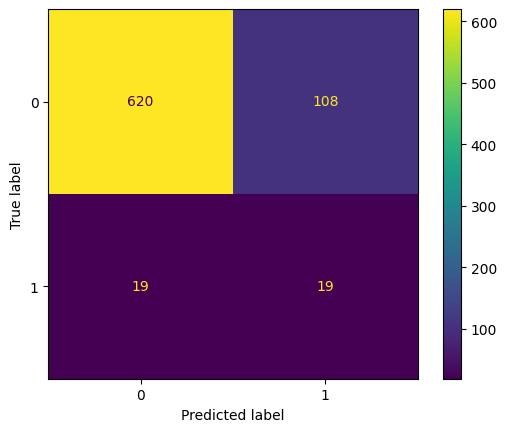

In [32]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train_res, y_train_res)

y_val_pred = gbc.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm_disp_gbc = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred))
cm_disp_gbc.plot();

In [33]:
param_grid_gbc = {
    'loss': ['log_loss', 'exponential'],
    'criterion':['friedman_mse','squared_error'],
    'learning_rate': [0.1,1, 2],
    'n_estimators': [100, 200, 300]
} 

gbc_hptune = GridSearchCV(gbc, param_grid_gbc, scoring="recall")
gbc_hptune.fit(X_train_res, y_train_res)

GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': [0.1, 1, 2],
                         'loss': ['log_loss', 'exponential'],
                         'n_estimators': [100, 200, 300]},
             scoring='recall')

Best Logistic Regression Accuracy: 0.9399477806788512
Best Params: {'criterion': 'friedman_mse', 'learning_rate': 1, 'loss': 'exponential', 'n_estimators': 200}


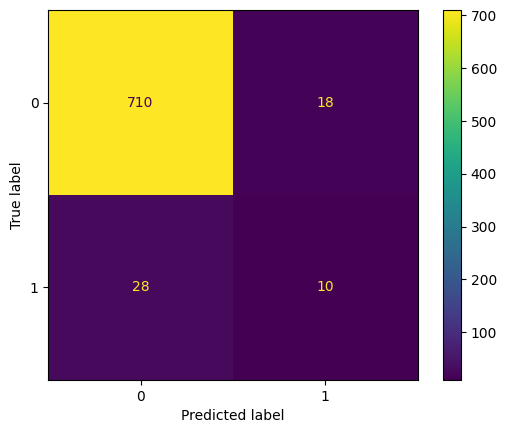

In [34]:
best_gbc = gbc_hptune.best_estimator_
print(f"Best Logistic Regression Accuracy: {best_gbc.score(X_val, y_val)}")
print(f"Best Params: {gbc_hptune.best_params_}")
cm_disp_gbc = ConfusionMatrixDisplay(confusion_matrix(y_val, best_gbc.predict(X_val)))
cm_disp_gbc.plot()

This model performed similarly to the Random Forest Clasifier - it was very effecitve at identifying negative diagnoses but ineffective at diagnosing positive diagnoses.

### 3.6 Linear Discriminant Analysis

              precision    recall  f1-score   support

           0       0.98      0.69      0.81       728
           1       0.11      0.76      0.20        38

    accuracy                           0.70       766
   macro avg       0.55      0.73      0.51       766
weighted avg       0.94      0.70      0.78       766



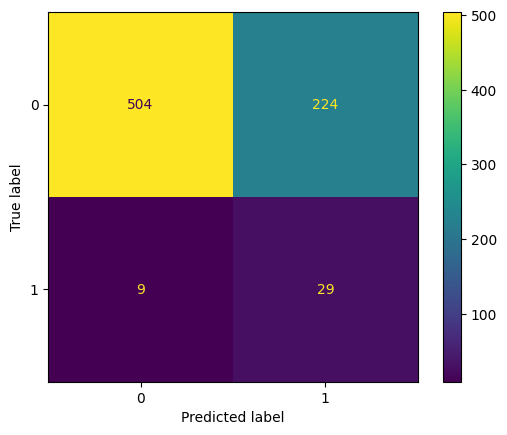

In [35]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_res, y_train_res)

y_val_pred = lda.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm_disp_lda = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred))
cm_disp_lda.plot();

In [36]:
param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage':['auto',None],
    'covariance_estimator': [None, 1]
} 

lda_hptune = GridSearchCV(lda, param_grid_lda, scoring="recall")
lda_hptune.fit(X_train_res, y_train_res)

C:\Users\abhir\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
35 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\abhir\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\abhir\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\abhir\AppData\Local\Programs\Python\Python38\lib\site-packages\skl

GridSearchCV(estimator=LinearDiscriminantAnalysis(),
             param_grid={'covariance_estimator': [None, 1],
                         'shrinkage': ['auto', None],
                         'solver': ['svd', 'lsqr', 'eigen']},
             scoring='recall')

Best Logistic Regression Accuracy: 0.6971279373368147
Best Params: {'covariance_estimator': None, 'shrinkage': 'auto', 'solver': 'lsqr'}


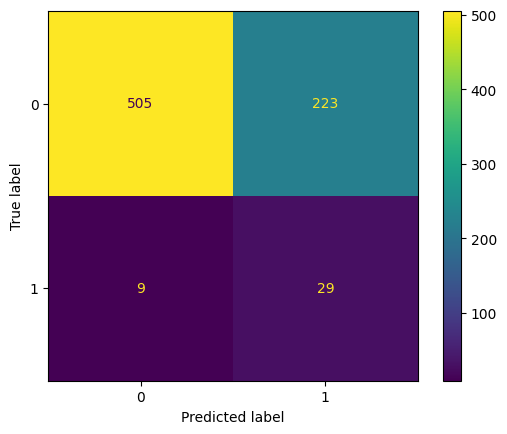

In [37]:
best_lda = lda_hptune.best_estimator_
print(f"Best Logistic Regression Accuracy: {best_lda.score(X_val, y_val)}")
print(f"Best Params: {lda_hptune.best_params_}")
cm_disp_lda = ConfusionMatrixDisplay(confusion_matrix(y_val, best_lda.predict(X_val)))
cm_disp_lda.plot()

This model was very promising, it predicted positive diagnoses equally as effectively as the Adaptive Boosting model, but produced slightly fewer false positives. <br>
Now we will compare all models we tested and establish, which we will use as our final model

### Hypertuning Comparison

In [41]:
from sklearn.metrics import log_loss

best_classifiers = [
    best_adab, best_gbc, best_knn, best_lda, best_nu, best_rfc
              ]
for clf in best_classifiers:
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_val)
    acc = accuracy_score(y_val, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    ll = log_loss(y_val, train_predictions)
    print("Log Loss: {}".format(ll))
        
print("="*30)

AdaBoostClassifier
****Results****
Accuracy: 73.8903%
Log Loss: 9.410875558516228
GradientBoostingClassifier
****Results****
Accuracy: 93.9948%
Log Loss: 2.1645013784587324
KNeighborsClassifier
****Results****
Accuracy: 81.5927%
Log Loss: 6.634667268753941
LinearDiscriminantAnalysis
****Results****
Accuracy: 69.7128%
Log Loss: 10.916615647878825
NuSVC
****Results****
Accuracy: 84.0731%
Log Loss: 5.740634090694899
RandomForestClassifier
****Results****
Accuracy: 90.4700%
Log Loss: 3.4349695788584236


In [42]:
model_name = []
accuracy = []
precision = []
recall = []
f1 = []

for clf in best_classifiers:
    y_val_pred = clf.predict(X_val)
    
    model_name.append(type(clf).__name__) 
    accuracy.append(accuracy_score(y_val, y_val_pred))
    precision.append(precision_score(y_val, y_val_pred))
    recall.append(recall_score(y_val, y_val_pred))
    f1.append(f1_score(y_val, y_val_pred))

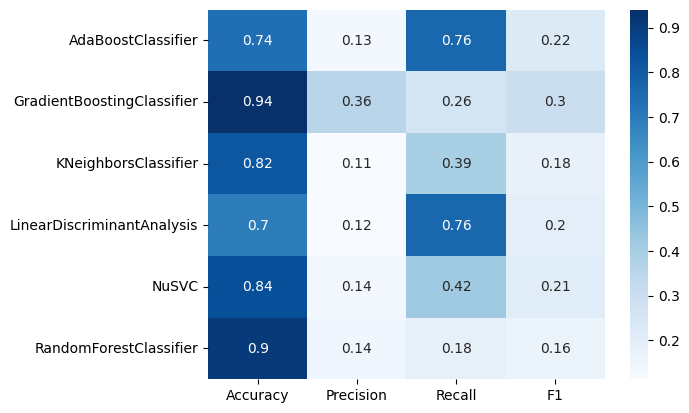

In [43]:
results = pd.DataFrame({'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1},
                      index=model_name)
sns.heatmap(results, annot=True, cmap='Blues');

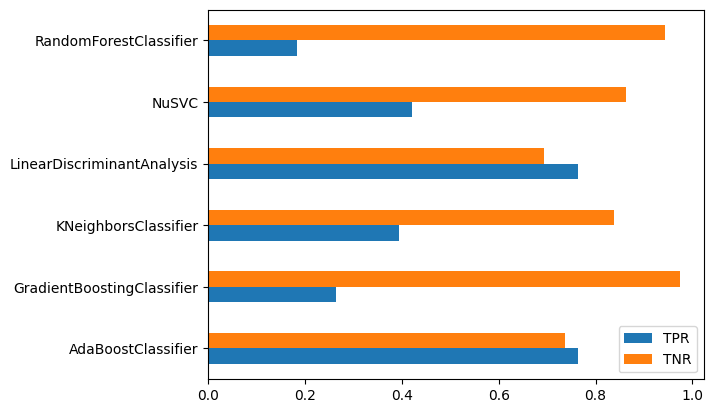

In [44]:
from sklearn.metrics import roc_curve

tpr_lst = []
tnr_lst = []

for clf in best_classifiers:
    matrix = confusion_matrix(y_val, clf.predict(X_val))
     
    tn = matrix[0][0]
    fp = matrix [0][1]
    tp = matrix [1][1]
    fn = matrix[1][0]
    
    tpr = tp/(tp+fn)
    tpr_lst.append(tpr)
    
    tnr = tn/(tn+fp)
    tnr_lst.append(tnr)
    

models_tpr_npr = pd.DataFrame({'TPR': tpr_lst, 'TNR': tnr_lst}, index=model_name)

models_tpr_npr.plot(kind='barh');

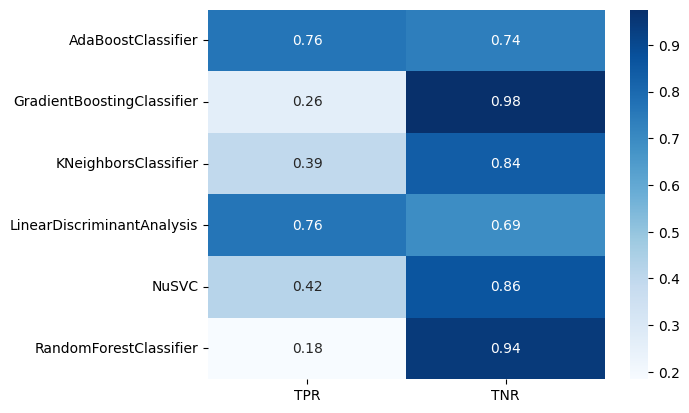

In [45]:
sns.heatmap(models_tpr_npr, annot=True, cmap="Blues");

After comparing the results of our tuned models, the best suited model appears to be the AdaBoost model. Hence, we will use this model going forward

## 4 - Final Model & Results

In [46]:
final_model = best_adab
y_test_pred = final_model.predict(X_test)

We will now test our final model on our unseen test dataset

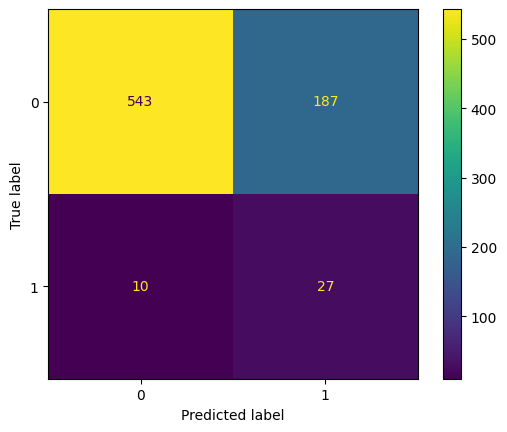

In [47]:
cm_test = confusion_matrix(y_test, y_test_pred)
cm_disp_test = ConfusionMatrixDisplay(cm_test)
cm_disp_test.plot();

In [48]:
fp = cm_test[0][1]
tp = cm_test[1][1]
fn = cm_test[1][0]
    
tpr = tp/(tp+fn)   
tnr = tn/(tn+fp)

print(f"True Positive Rate: {tpr}")
print(f"True Negative Rate: {tnr}")
print(f"Accuracy: {final_model.score(X_test, y_test)}")

True Positive Rate: 0.7297297297297297
True Negative Rate: 0.7857961053837342
Accuracy: 0.7431551499348109


The model seems to function very well! With a true-negative rate of 79%, our model is able to catch strokes in roughly 4 out 5 patients.

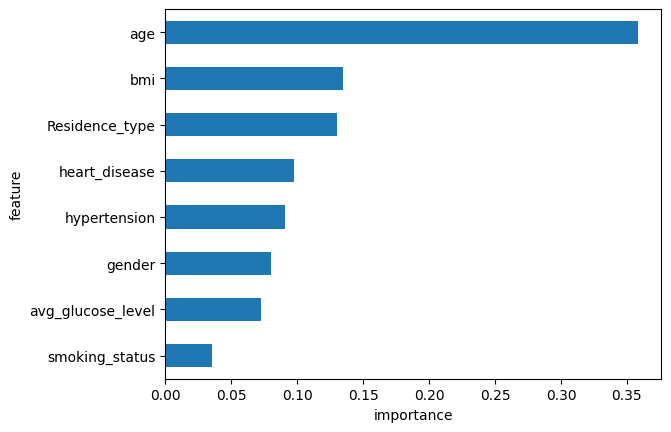

In [49]:
final_model.fit(X_train_res, y_train_res)
feature_importances = pd.Series(final_model.feature_importances_, index= final_model.feature_names_in_).sort_values(ascending=True)

feature_importances.plot(kind='barh', xlabel='importance', ylabel='feature');

We can also see that, according to our model, the top 5 greatest factors affecting stroke occurences are:
1. Age
2. BMI
3. Residence Type
4. Heart Disease
5. Hypertension

Most of these features are not surprising. However the inclusion of residence type in this top 5 is somewhat surprising. Interestingly this is corroborated by resarch. A research article on the [Urban-rural differences in risk factors for ischemic stroke in northern China](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6571368/#R5) outlines this difference, with rural areas in Northern China being more susceptible to stroke occurences